In [25]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from scipy.optimize import minimize
from copy import deepcopy
import time
from qiskit.aqua.operators import WeightedPauliOperator, MatrixOperator
from qiskit.quantum_info import Pauli
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import random
from qiskit.compiler import transpile
from qiskit.circuit import Parameter
from qiskit.aqua.components.optimizers import ADAM
import warnings

In [26]:
warnings.simplefilter("ignore")

In [ ]:
# global変数の宣言

In [27]:
nqubit = 2
depth = 1

In [28]:
# 結果を入れるhashmap
d = {}

In [ ]:
# ここで入力データを作成

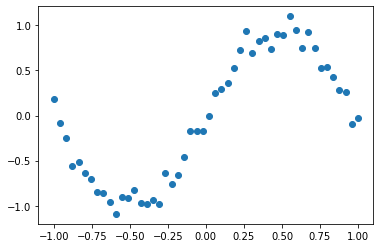

In [29]:
########  パラメータ  #############
## [x_min, x_max]のうち, ランダムにnum_x_train個の点をとって教師データとする.
x_min = - 1.; x_max = 1.;
num_x_train = 50
num_x_test = 50

## 学習したい1変数関数
func_to_learn = lambda x: np.sin(x*np.pi)
func_to_learn1 = lambda x:np.abs(x)
func_to_learn2 = lambda x:x
func_to_learn3 = lambda x:np.exp(x)
func_to_learn4 = lambda x:np.cos(np.pi*x)
func_to_learn5 = lambda x:x**2

## 乱数のシード
random_seed = 3
## 乱数発生器の初期化
np.random.seed(random_seed)
### 教師データを準備
x_train = np.linspace(-1,1,50)
y_train = func_to_learn(x_train)

# 現実のデータを用いる場合を想定し、きれいなsin関数にノイズを付加
mag_noise1 = 0.1
y_train = y_train + mag_noise1 * np.random.randn(num_x_train)

#テストデータの準備
mag_noise2 = 0.1
x_test = np.linspace(-1,1,50)
y_test = func_to_learn(x_test) + mag_noise2 * np.random.randn(num_x_test)

plt.plot(x_train, y_train, "o"); plt.show()

In [30]:
numTrainData = len(x_train)

In [31]:
theta_list = [Parameter(str(i)) for i in range(3*nqubit*depth)]
par =  np.random.normal(0,1/np.sqrt(numTrainData),3*nqubit*depth)

In [32]:
qc_map = {}  
# x_train内のindex:対応するQuantumCircuitオブジェクト
#これはdepthやnqubitを変えるたびに初期化する
# テストデータに関しては1回ずつしか呼び出されないから特に保存しない

In [33]:
#ここでハミルトニアンを作り、使いまわす
pauli_list = []
evo_time = 10
# ΣaXに相当する部分をpauli_listに加える
for i in range(nqubit):
    a = random.uniform(-1,1)
    x = np.array([False if j != i else True for j in range(nqubit)],dtype=bool)
    z = np.array([False]*nqubit,dtype=bool)
    pauli_list.append([a,Pauli(z,x)])
# ΣJZZに相当する部分をpauli_listに加える
for i in range(nqubit):
    for k in range(i):
        J = random.uniform(-1,1)
        x = np.array([False]*nqubit,dtype=bool)
        z = np.array([True if (j == i or j == k) else False for j in range(nqubit)],dtype=bool)
        pauli_list.append([J,Pauli(z,x)])
qubitOp = WeightedPauliOperator(paulis=pauli_list)

In [34]:
def U_in(x):    #入力xをエンコードするゲートが付いた回路（QuantumCircuit）を返す
    # 入力が1次元か多次元化に応じて少しコードを変える
    U = QuantumCircuit(nqubit)
    for i in range(nqubit):
        angle_y = np.arcsin(x)
        angle_z = np.arccos(x**2)
        U.ry(angle_y,[i])
        U.rz(angle_z,[i])
    
    return U
# 入力次元が1の場合でもリストで渡す必要がある

In [35]:
def ansatz(depth):  #入力パラメータ初期値のリスト、出力アンザッツが含まれた回路（QuantumCircuit）を返す
    U = QuantumCircuit(nqubit)
    U += qubitOp.evolve(
    U, evo_time, num_time_slices=1,
    expansion_mode='suzuki',
    expansion_order=3
)
    
    for i in range(nqubit):
        U.rx(theta_list[(3*nqubit*depth)+i],i)
    for i in range(nqubit):
        U.rz(theta_list[(3*nqubit*depth)+i+nqubit],i)
    for i in range(nqubit):
        U.rx(theta_list[(3*nqubit*depth)+2*nqubit+i],i)
    return U

In [36]:
def getoutput(x,init_par):   #入力x(リスト)、出力yの予測値
    # 入力が1次元なら(x,), 多次元ならtuple(x)とする
    tupled_x = (x,)
    if tupled_x in qc_map:
        qc = qc_map[tupled_x]
    else:
        qc = U_in(x)
        for i in range(depth):
            qc += ansatz(i)
        qc_map[tupled_x] = qc
    backend = Aer.get_backend("statevector_simulator")
    job = execute(qc,backend,parameter_binds=[{theta_list[i]:init_par[i] for i in range(len(init_par))}])
    counts = job.result().get_counts()
    res = 0
    for key in counts.keys():
        if key[-1] == "0":
            res += counts[key]
        else:
            res -= counts[key]
    return 2*res
#counts[i]にしないとresは０にしかならない

In [37]:
def cost_func_helper(x,y,par):
    y_pred = getoutput(x,par)
    return 0.5 * ((y - y_pred)**2)

In [38]:
def cost_func(par):
    res = 0
    for x,y in zip(x_train,y_train):
        res += cost_func_helper(x,y,par)
    return res

In [39]:
def gene_error(par):
    # 現在のパラメータ値がparの時のテストデータに対するコスト関数の値を返す
    res = 0
    for x,y in zip(x_test,y_test):
        res += cost_func_helper(x,y,par)
    return res

In [45]:
def deriv_func(par):
    res = []
    n = len(par)
    data = it.next()  # このデータだけを使って勾配を求める
    numdata = len(data)  # バッチサイズと同じ
    x_data = [data[i][0] for i in range(numdata)]  # data[i] = (x,y)というタプルなのでxのみ取り出す
    y_pred = [getoutput(x,par) for x in x_data]
    for i in range(n):
        temp = 0
        for j in range(numdata):
            x,y = data[j][0],data[j][1]
            temp += (y_pred[j] - y) * compute_gradient1(x,par,i)
        res.append(temp)
    res = np.array(res)
    return res

In [41]:
def compute_gradient1(x,par,i):
    par[i] += np.pi/2
    b_plus = getoutput(x,par)
    par[i] -= np.pi/2
    par[i] -= np.pi/2
    b_minus = getoutput(x,par)
    par[i] += np.pi/2
    return (b_plus - b_minus)/2

In [42]:
class Iterator:
    def __init__(self,x,y,batch_size):
        self.x = x_train   # 訓練データの入力、ndarray
        self.y = y_train   # 訓練データの出力、ddarray
        self.batch_size = batch_size  # バッチサイズ(1以上)
        self.index = 0  # データ内のどのindexを見ているかを保持する
        self.indices = list(range(len(x_train)))  # この配列を適宜シャッフルする
        
    def next(self):   # バッチサイズ分のデータをリストに入れて変えす、途中でデータを見終わったらシャッフルする
        res = []
        for _ in range(self.batch_size):
            nx = self.x[self.indices[self.index]]
            ny = self.y[self.indices[self.index]]
            res.append((nx,ny))
            self.index += 1
            if self.index == len(self.x):
                self.index = 0
                np.random.shuffle(self.indices)
        res = np.array(res)
        return res

In [ ]:
# ここから学習

In [ ]:
start = time.time()
adam = ADAM(maxiter = 10)
it = Iterator(x = x_train,y = y_train,batch_size = 1)
par,mincost,_ = adam.minimize(cost_func,par,deriv_func)  # (最適パラメータ、その時のコスト関数値、イテレーション数)を返す
d[depth] = d.get(depth,[]) + [(par,mincost,gene_error(par))]  # (最適パラメータ、その時のコスト関数値、その時のテストデータに対するコスト関数値)を保存

process_time = time.time() - start

print(d[depth])
print(process_time)

In [ ]:
# ここから結果の解釈(結果の図示や情報量の計算を行う)

In [ ]:
# プロットしたいときには以下を実行すればよい
plt.figure(figsize=(10, 6))

xlist = np.arange(x_min, x_max, 0.02)

# 教師データ
plt.plot(x_train, y_train, "o", label='Teacher')

# モデルの予測値
y_pred = np.array([getoutput(x,par) for x in xlist])
plt.plot(xlist, y_pred, label='Final Model Prediction')

plt.legend()
plt.show()